In [1]:
#imports
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegressionCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV



## Load and Normalize Data

In [2]:
#Load Data
merged_data_clean_relevant = pd.read_csv("../Behavioural_Data_MPILMBB_LEMON/merged_data_clean_relevant.csv")
relationship_status = pd.read_csv("../Behavioural_Data_MPILMBB_LEMON/relationship_status.csv")
age_group = pd.read_csv("../Behavioural_Data_MPILMBB_LEMON/age_group.csv")

print(relationship_status.sum())
print(merged_data_clean_relevant)

Relationship_Status    156
dtype: int64
     LPS_1  TAP_WM_1  TAP_WM_6  CERQ_SelfBlame  CERQ_Acceptance  \
0       27     613.0        15        2.333333         1.666667   
1       24     693.0        13        1.666667         2.666667   
2       25     551.0        15        2.000000         2.666667   
3       17     705.0        14        2.000000         1.666667   
4       20     509.0         8        1.666667         3.333333   
..     ...       ...       ...             ...              ...   
219     23     420.0        13        2.000000         2.000000   
220     23     420.0        13        2.000000         2.000000   
221     23     420.0        13        2.000000         2.000000   
222     23     420.0        13        2.000000         2.000000   
223     20     585.0        15        2.000000         2.666667   

     CERQ_Rumination  CERQ_positiveRefocusing  CERQ_RefocusOnPlanning  \
0           2.000000                 1.000000                1.333333   
1        

In [3]:
#normalize data
scaler = RobustScaler()
merged_data_clean_scaled = scaler.fit_transform(merged_data_clean_relevant)

#Dataframe with normalized columsn and header
merged_data_clean_scaled_dataframe = pd.DataFrame(merged_data_clean_scaled, columns=merged_data_clean_relevant.columns)

## Train-/Test-Split


In [4]:
relationship_array = relationship_status["Relationship_Status"]

In [5]:
# Split into training and test sets by keeping the ration of people in a relationship to people not the same for training and test set. 
X_train, X_test, Y_train, Y_test = train_test_split(merged_data_clean_scaled, relationship_array, test_size=0.2, stratify=relationship_array, random_state=42)

In [6]:
# Optional: Check class proportions

print("Class distribution in y_train:", dict(zip(*np.unique(Y_train, return_counts=True))))
print("Class distribution in y_test:", dict(zip(*np.unique(Y_test, return_counts=True))))

Class distribution in y_train: {0: 54, 1: 125}
Class distribution in y_test: {0: 14, 1: 31}


## Training

### Logistic Regression

In [7]:
#set up learning function 
#set up cross validation. 
# Train

# set hyperparameters
n_folds = 10
n_alphas = 10
max_iter = 5000

# define models
ridge_model = LogisticRegressionCV(penalty="l2", n_jobs = 16, max_iter=max_iter, fit_intercept=False, random_state=1, solver='saga', cv=n_folds, Cs=n_alphas)

# INSERT YOUR CODE HERE
logreg_ridge_cv = ridge_model.fit(X_train, Y_train)

In [8]:
# Cross-validated accuracy scores for each fold
cv_scores = logreg_ridge_cv.scores_[1]  # For the positive class (1)

# Mean accuracy across folds
mean_cv_accuracy = cv_scores.mean()

# Print the cross-validated accuracy
print(f"Mean cross-validated accuracy: {mean_cv_accuracy:.4f}")

Mean cross-validated accuracy: 0.6384


### Random Forest

#### Model Training using GridSearch with Cross Validation

In [9]:


# Define parameter grid
param_grid = {
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'n_estimators': [10, 25, 50, 100, 150],
    'max_features': ['sqrt', 'log2',None]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced', random_state=42), #The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))
    param_grid=param_grid,
    cv=5,       # Cross-validation folds
    scoring='f1_weighted',
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train, Y_train)

# Best Parameters
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 150}


#### Evaluation on Test Set

In [10]:
# Use the best model for predictions
best_rf_model = grid_search.best_estimator_

# Test Model on Test Set
y_pred = best_rf_model.predict(X_test)

# Evaluate the best model
results = classification_report(Y_test, y_pred, output_dict=True)
print(results)
print("weighted average F1 Score: " + str(results["weighted avg"]["f1-score"]))


{'0': {'precision': 0.6, 'recall': 0.42857142857142855, 'f1-score': 0.5, 'support': 14.0}, '1': {'precision': 0.7714285714285715, 'recall': 0.8709677419354839, 'f1-score': 0.8181818181818182, 'support': 31.0}, 'accuracy': 0.7333333333333333, 'macro avg': {'precision': 0.6857142857142857, 'recall': 0.6497695852534562, 'f1-score': 0.6590909090909092, 'support': 45.0}, 'weighted avg': {'precision': 0.7180952380952381, 'recall': 0.7333333333333333, 'f1-score': 0.7191919191919193, 'support': 45.0}}
weighted average F1 Score: 0.7191919191919193


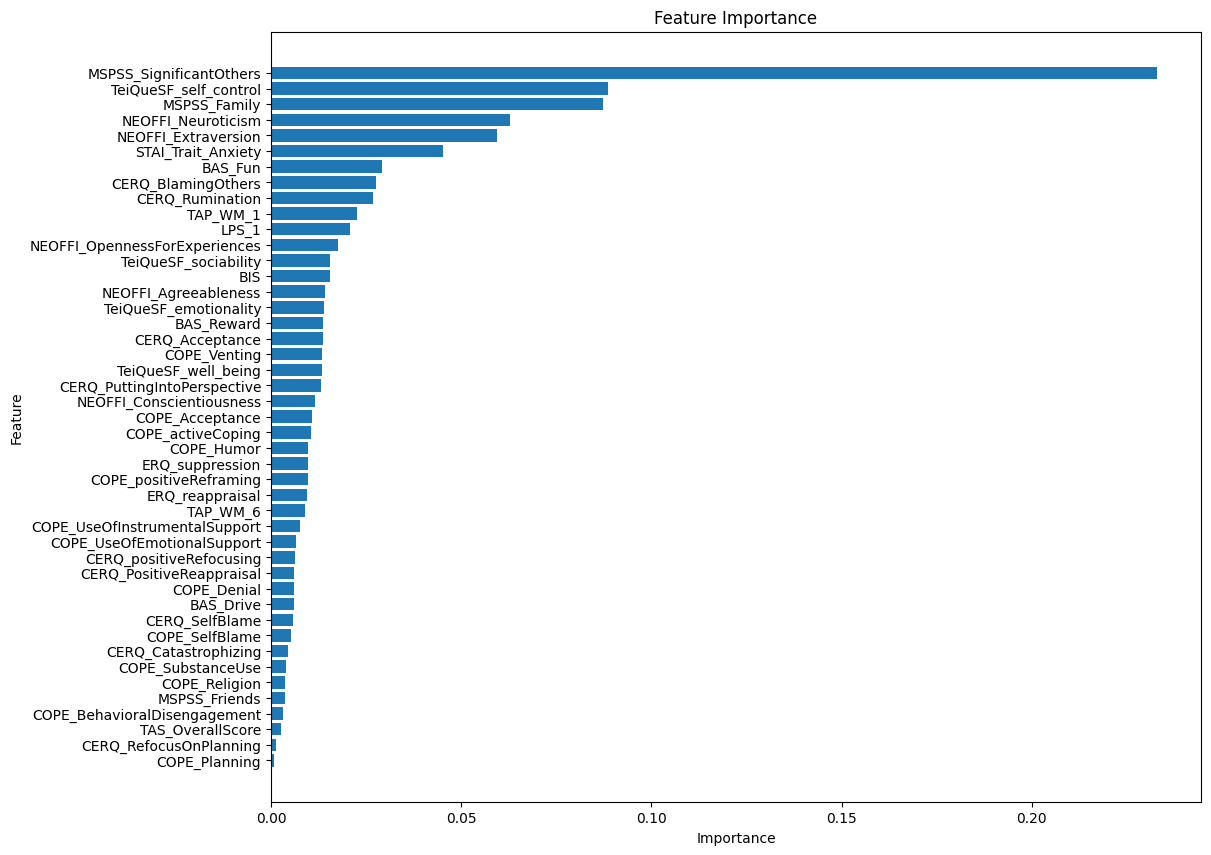

In [11]:
# Feature Importance
feature_importances = pd.DataFrame({
    'Feature': merged_data_clean_scaled_dataframe.columns,
    'Importance': best_rf_model.feature_importances_
}).sort_values(by='Importance', ascending=True)

# Plot
plt.figure(figsize=(12, 10))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [20]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, classification_report

# Dummy Classifier Training with Cross-Validation
def train_dummy_classifier_cv(X_train, Y_train, X_test, Y_test, cv=5):
    # Initialize Dummy Classifier
    dummy_clf = DummyClassifier(strategy="stratified")  # Predicts the most frequent class

    # Perform Cross-Validation
    cv_scores = cross_val_score(dummy_clf, X_train, Y_train, cv=cv, scoring="f1_weighted")

    # Train on full dataset to generate a classification report
    dummy_clf.fit(X_train, Y_train)

    #Predict on Test Set
    y_pred_dummy = dummy_clf.predict(X_test)
    dummy_report = classification_report(Y_test, y_pred_dummy, output_dict=True)
    
    print("Dummy Classifier Cross-Validation Performance:")
    print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (± {cv_scores.std():.4f})")
    print(dummy_report)
    print("weighted average F1 Score: " + str(dummy_report["weighted avg"]["f1-score"]))
    
    return cv_scores, dummy_report

# Train Dummy Classifier using Cross-Validation
dummy_cv_scores, dummy_cv_report = train_dummy_classifier_cv(X_train, Y_train, X_test, Y_test, cv=5)

Dummy Classifier Cross-Validation Performance:
Mean CV Accuracy: 0.5683 (± 0.0619)
{'0': {'precision': 0.05555555555555555, 'recall': 0.07142857142857142, 'f1-score': 0.0625, 'support': 14.0}, '1': {'precision': 0.5185185185185185, 'recall': 0.45161290322580644, 'f1-score': 0.48275862068965514, 'support': 31.0}, 'accuracy': 0.3333333333333333, 'macro avg': {'precision': 0.28703703703703703, 'recall': 0.26152073732718895, 'f1-score': 0.27262931034482757, 'support': 45.0}, 'weighted avg': {'precision': 0.3744855967078189, 'recall': 0.3333333333333333, 'f1-score': 0.35201149425287354, 'support': 45.0}}
weighted average F1 Score: 0.35201149425287354


## Analysis of Important Features

In [14]:
# Define new feature set without the best feature
filtered_features = [feat for feat in merged_data_clean_scaled_dataframe.columns if feat != "MSPSS_SignificantOthers"]

# Create new feature matrix without the best feature
X_filtered = merged_data_clean_scaled_dataframe[filtered_features]
y = relationship_array

X_train, X_test, Y_train, Y_test = train_test_split(X_filtered, y, test_size=0.2, stratify=y, random_state=42)

In [15]:
# GridSearchCV für das optimierte Modell
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced', random_state=42), 
    param_grid=param_grid,
    cv=5,       
    scoring='f1_weighted',
    n_jobs=-1
)

# Trainiere das Modell
grid_search.fit(X_train, Y_train)

# Bestes Modell speichern
best_rf_model = grid_search.best_estimator_

# Beste Hyperparameter ausgeben
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}


In [16]:
# Define parameter grid
merged_data_clean_scaled_dataframe_ohne_MSPSS = merged_data_clean_scaled_dataframe.drop(columns=["MSPSS_SignificantOthers"])

merged_data_clean_relevant_MSPSS = merged_data_clean_relevant.drop(columns=["MSPSS_SignificantOthers"])
#normalize data
scaler = RobustScaler()
merged_data_clean_scaled_MSPSS = scaler.fit_transform(merged_data_clean_relevant_MSPSS)

#Dataframe with normalized columsn and header
merged_data_clean_scaled_dataframe_MSPSS = pd.DataFrame(merged_data_clean_scaled_MSPSS, columns=merged_data_clean_relevant_MSPSS.columns)

X_train, X_test, Y_train, Y_test = train_test_split(merged_data_clean_scaled_MSPSS, relationship_array, test_size=0.2, stratify=relationship_array, random_state=42)

param_grid = {
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'n_estimators': [10, 25, 50, 100, 150],
    'max_features': ['sqrt', 'log2',None]
}

# Initialize GridSearchCV
grid_search_2 = GridSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced', random_state=42), #The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))
    param_grid=param_grid,
    cv=5,       # Cross-validation folds
    scoring='f1_weighted',
    n_jobs=-1
)

# Fit the model
grid_search_2.fit(X_train, Y_train)

# Best Parameters
print("Best Parameters:", grid_search_2.best_params_)

best_model_MSPSS = grid_search_2.best_estimator_
# Test Model on Test Set
y_pred_2 = best_model_MSPSS.predict(X_test)

# Evaluate the best model
results = classification_report(Y_test, y_pred_2, output_dict=True)
print(results)
print("weighted average F1 Score: " + str(results["weighted avg"]["f1-score"]))


Best Parameters: {'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
{'0': {'precision': 0.5555555555555556, 'recall': 0.35714285714285715, 'f1-score': 0.43478260869565216, 'support': 14.0}, '1': {'precision': 0.75, 'recall': 0.8709677419354839, 'f1-score': 0.8059701492537312, 'support': 31.0}, 'accuracy': 0.7111111111111111, 'macro avg': {'precision': 0.6527777777777778, 'recall': 0.6140552995391705, 'f1-score': 0.6203763789746917, 'support': 45.0}, 'weighted avg': {'precision': 0.6895061728395062, 'recall': 0.7111111111111111, 'f1-score': 0.6904895810801066, 'support': 45.0}}
weighted average F1 Score: 0.6904895810801066


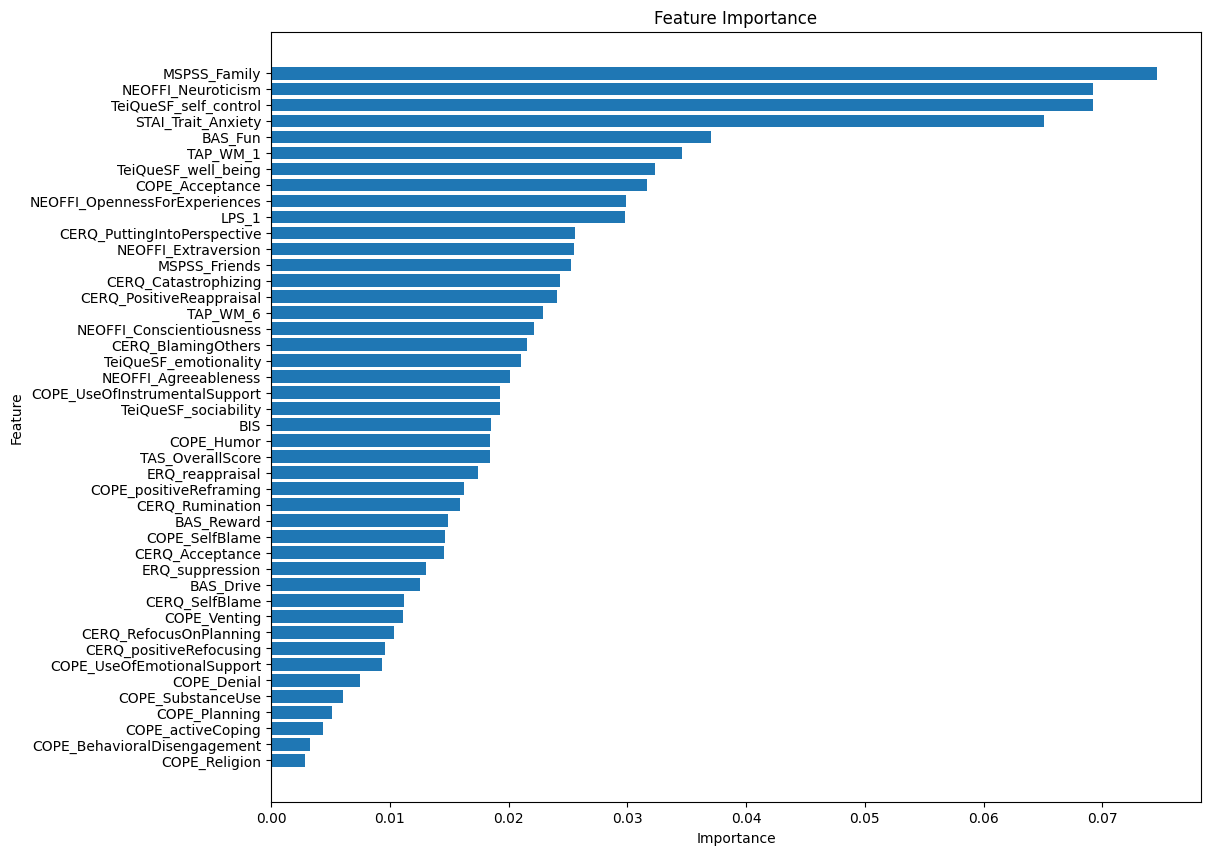

In [21]:
# Feature Importance

feature_importances_wo_MSPSS = pd.DataFrame({
    'Feature': merged_data_clean_scaled_dataframe_MSPSS.columns,
    'Importance': best_model_MSPSS.feature_importances_
}).sort_values(by='Importance', ascending=True)

# Plot
plt.figure(figsize=(12, 10))
plt.barh(feature_importances_wo_MSPSS['Feature'], feature_importances_wo_MSPSS['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [311]:

# Vergleich der Cross-Validation Scores
comparison_df = pd.DataFrame({
    "Model": ["With MSPSS_SignificantOthers", "Without MSPSS_SignificantOthers"],
    "Mean Weighted F1 Score": [cv_scores.mean(), cv_scores_filtered.mean()],
    "Standard Deviation": [cv_scores.std(), cv_scores_filtered.std()]
})

print(comparison_df)

                             Model  Mean Weighted F1 Score  Standard Deviation
0     With MSPSS_SignificantOthers                0.694325            0.077002
1  Without MSPSS_SignificantOthers                0.614112            0.105505


--------
### Feature Analysis and Importance referring to relationship status

In [22]:
# Convert relationship_status column to a DataFrame
relationship_df = pd.DataFrame(relationship_status["Relationship_Status"].values, columns=["Relationship_Status"])

# Ensure the index of relationship_df matches merged_data_clean_scaled_dataframe
relationship_df.index = merged_data_clean_scaled_dataframe.index  

# Append Relationship_Status as a new column
merged_data_clean_scaled_dataframe["Relationship_Status"] = relationship_df

# Verify if the column was added correctly
print(merged_data_clean_scaled_dataframe.head())

      LPS_1  TAP_WM_1  TAP_WM_6  CERQ_SelfBlame  CERQ_Acceptance  \
0  1.333333  0.287454  0.333333             1.5            -0.50   
1  0.833333  0.677223 -0.333333             0.5             0.25   
2  1.000000 -0.014616  0.333333             1.0             0.25   
3 -0.333333  0.735688  0.000000             1.0            -0.50   
4  0.166667 -0.219245 -2.000000             0.5             0.75   

   CERQ_Rumination  CERQ_positiveRefocusing  CERQ_RefocusOnPlanning  \
0             0.25                    -0.50                   -1.00   
1             0.00                    -0.25                   -1.25   
2            -0.25                    -0.25                    0.75   
3            -0.25                     0.50                    0.50   
4             0.00                    -0.50                   -1.00   

   CERQ_PositiveReappraisal  CERQ_PuttingIntoPerspective  ...  COPE_Planning  \
0                     -0.25                        -0.75  ...           -0.5   
1   

In [23]:
# Split the dataset into two groups
relationship_yes = merged_data_clean_scaled_dataframe[merged_data_clean_scaled_dataframe["Relationship_Status"] == 1]
relationship_no = merged_data_clean_scaled_dataframe[merged_data_clean_scaled_dataframe["Relationship_Status"] == 0]

# Check the shape of the two groups
print(f"People in a relationship: {relationship_yes.shape[0]}")
print(f"People not in a relationship: {relationship_no.shape[0]}")

relationship_yes.head()

People in a relationship: 156
People not in a relationship: 68


,LPS_1,TAP_WM_1,TAP_WM_6,CERQ_SelfBlame,CERQ_Acceptance,CERQ_Rumination,CERQ_positiveRefocusing,CERQ_RefocusOnPlanning,CERQ_PositiveReappraisal,CERQ_PuttingIntoPerspective,...,COPE_Planning,COPE_Humor,COPE_Acceptance,COPE_Religion,COPE_SelfBlame,BIS,BAS_Drive,BAS_Fun,BAS_Reward,Relationship_Status
1,0.833333,0.677223,-0.333333,0.5,0.25,0.00,-0.25,-1.25,-1.25,-1.50,...,-1.0,-0.5,-0.5,0.0,0.5,0.50,-1.0,-0.5,-2.0,1
2,1.000000,-0.014616,0.333333,1.0,0.25,-0.25,-0.25,0.75,-0.50,-0.50,...,0.5,0.0,0.5,0.0,1.0,1.25,-0.5,0.0,-1.5,1
6,0.833333,-0.306943,0.333333,2.5,-0.25,-0.75,-1.25,1.00,0.75,0.75,...,0.5,-1.0,-0.5,0.0,2.0,1.50,0.5,-0.5,1.0,1
7,0.333333,0.004872,0.000000,4.0,0.50,0.50,-1.00,0.25,-1.50,-1.75,...,-0.5,-1.0,-2.0,0.0,1.5,-1.50,-2.0,-1.5,-2.5,1
8,0.333333,-0.404385,0.000000,1.5,0.50,-0.50,0.00,-1.00,-0.25,0.25,...,-1.0,0.0,-1.0,0.0,0.0,0.00,-1.0,-0.5,-1.0,1


Top 3 Features for Analysis: ['MSPSS_SignificantOthers', 'TeiQueSF_self_control', 'MSPSS_Family']


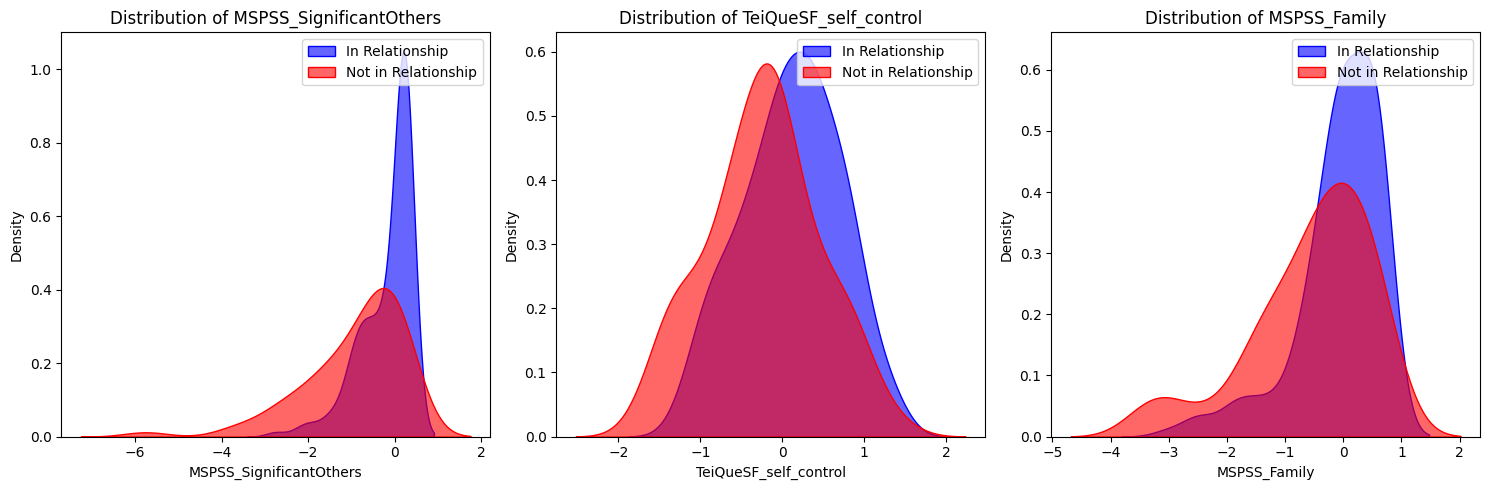

In [24]:


# Extract top 3 feature names
top_3_features = feature_importances.sort_values(by="Importance", ascending=False)["Feature"][:3].tolist()
print("Top 3 Features for Analysis:", top_3_features)

# Set up the figure
plt.figure(figsize=(15, 5))

for i, feature in enumerate(top_3_features):
    plt.subplot(1, 3, i + 1)
    
    # Plot distribution for both groups
    sns.kdeplot(relationship_yes[feature], label="In Relationship", fill=True, alpha=0.6, color="blue")
    sns.kdeplot(relationship_no[feature], label="Not in Relationship", fill=True, alpha=0.6, color="red")
    
    # Add title and labels
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Density")
    plt.legend()

plt.tight_layout()
plt.show()

ttest

/var/folders/7l/wr39ns_13xdbtxc49y6l0qjh0000gn/T/ipykernel_39945/1249002535.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged_data_clean_scaled_dataframe, x="Relationship_Status", y=feature, palette=["red", "blue"])
/var/folders/7l/wr39ns_13xdbtxc49y6l0qjh0000gn/T/ipykernel_39945/1249002535.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged_data_clean_scaled_dataframe, x="Relationship_Status", y=feature, palette=["red", "blue"])
/var/folders/7l/wr39ns_13xdbtxc49y6l0qjh0000gn/T/ipykernel_39945/1249002535.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=Fa

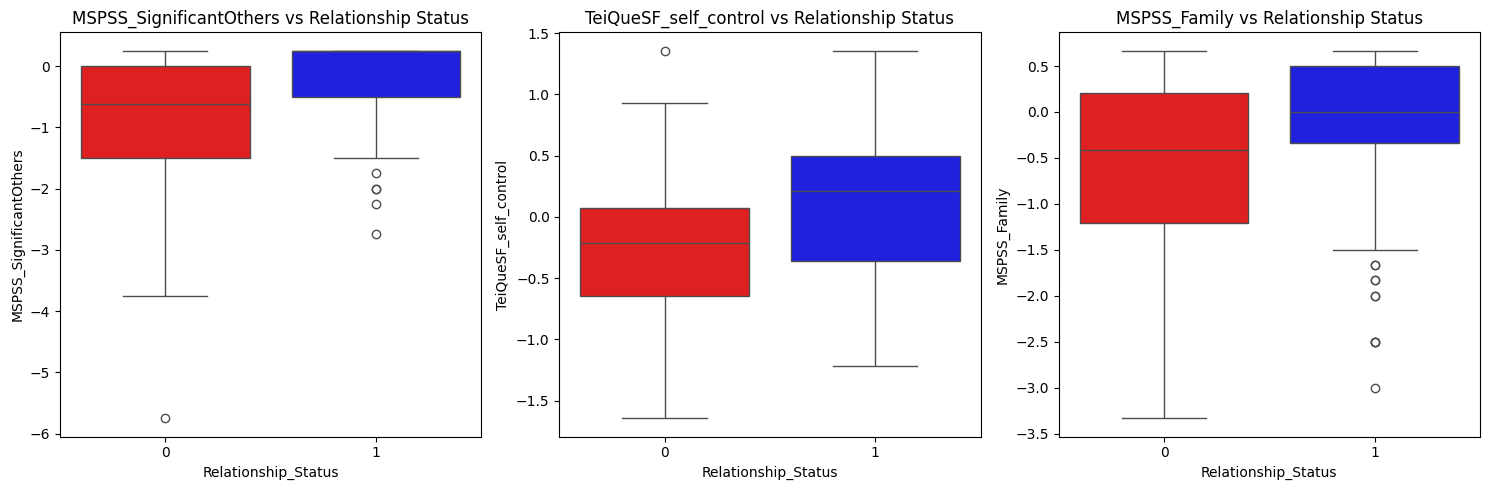

In [25]:
plt.figure(figsize=(15, 5))

for i, feature in enumerate(top_3_features):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(data=merged_data_clean_scaled_dataframe, x="Relationship_Status", y=feature, palette=["red", "blue"])
    plt.title(f"{feature} vs Relationship Status")

plt.tight_layout()
plt.show()

--------

### Density referring to the two Age Groups

In [26]:
# Konvertiere age_array in einen DataFrame
age_df = pd.DataFrame(age_group, columns=["Age_Group"])

# Stelle sicher, dass der Index mit merged_data_clean_scaled_dataframe übereinstimmt
age_df.index = merged_data_clean_scaled_dataframe.index  

# Füge Age_Group als neue Spalte hinzu
merged_data_clean_scaled_dataframe["Age_Group"] = age_df

# Überprüfe, ob die Spalte korrekt hinzugefügt wurde
print(merged_data_clean_scaled_dataframe.head())

      LPS_1  TAP_WM_1  TAP_WM_6  CERQ_SelfBlame  CERQ_Acceptance  \
0  1.333333  0.287454  0.333333             1.5            -0.50   
1  0.833333  0.677223 -0.333333             0.5             0.25   
2  1.000000 -0.014616  0.333333             1.0             0.25   
3 -0.333333  0.735688  0.000000             1.0            -0.50   
4  0.166667 -0.219245 -2.000000             0.5             0.75   

   CERQ_Rumination  CERQ_positiveRefocusing  CERQ_RefocusOnPlanning  \
0             0.25                    -0.50                   -1.00   
1             0.00                    -0.25                   -1.25   
2            -0.25                    -0.25                    0.75   
3            -0.25                     0.50                    0.50   
4             0.00                    -0.50                   -1.00   

   CERQ_PositiveReappraisal  CERQ_PuttingIntoPerspective  ...  COPE_Humor  \
0                     -0.25                        -0.75  ...         0.5   
1         

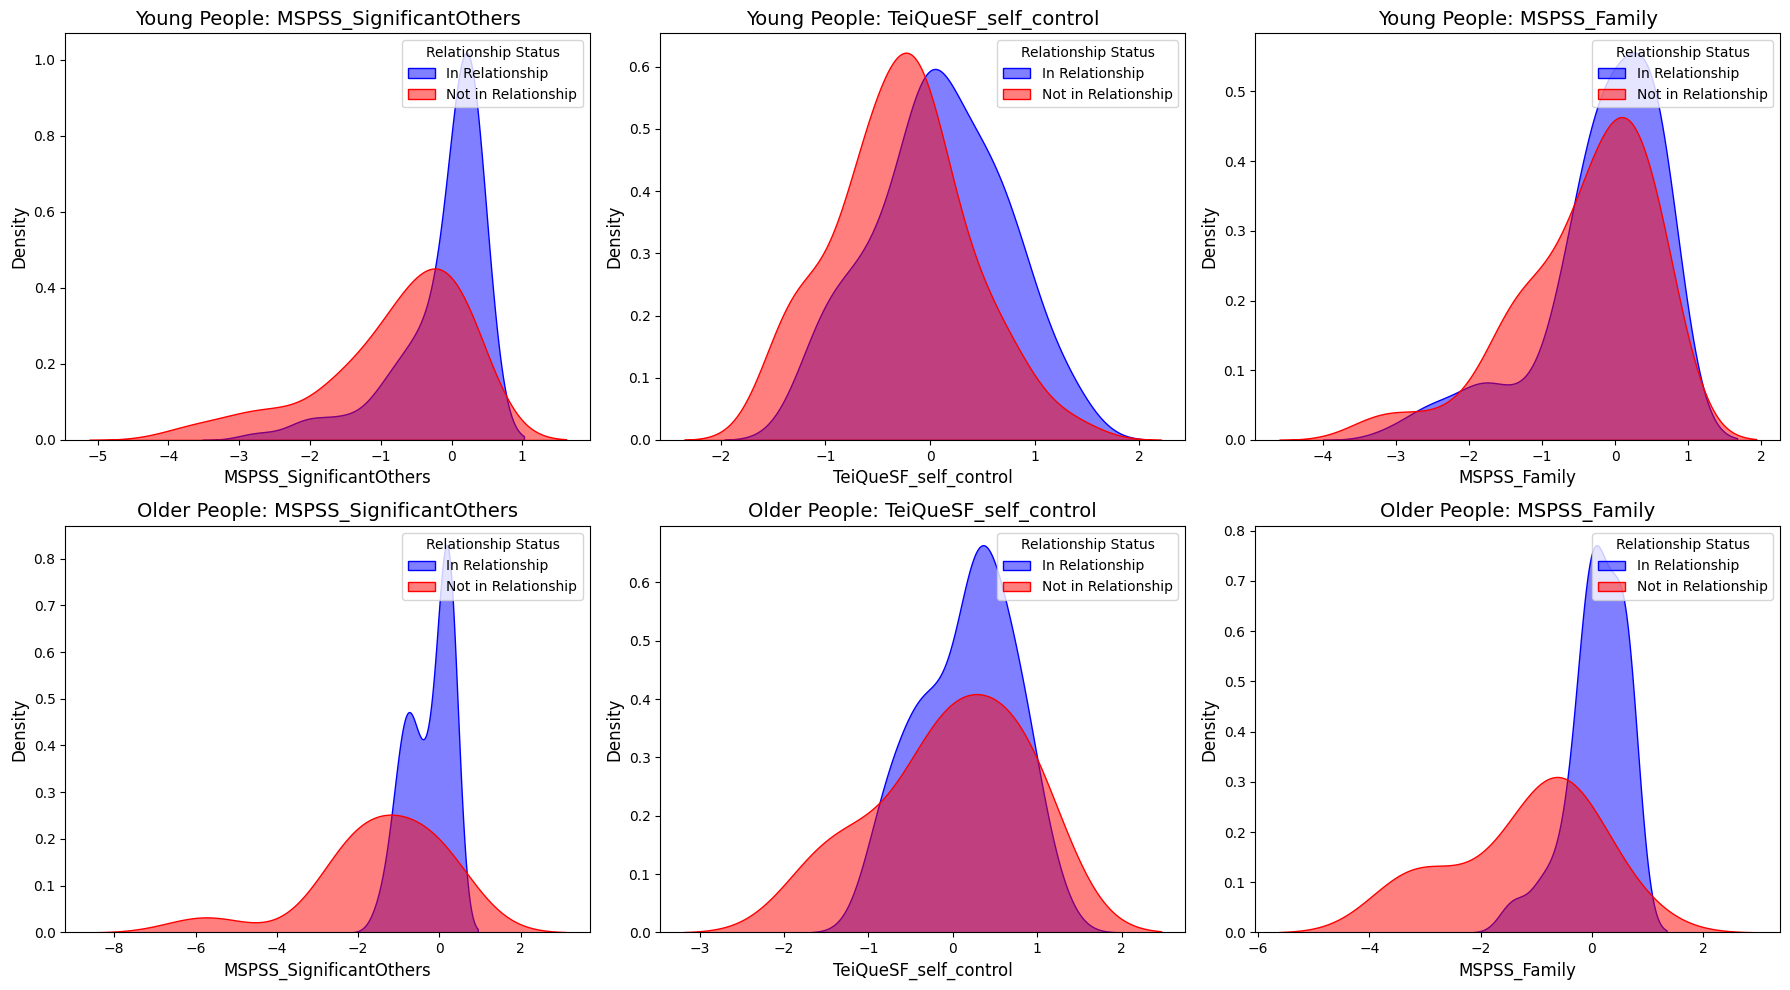

In [27]:
# Set up das Figure-Layout (2 Zeilen: Oben junge Leute, unten ältere)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for i, feature in enumerate(top_3_features):
    # **Obere Zeile: Junge Leute (Age Group = 0)**
    ax1 = axes[0, i]
    
    sns.kdeplot(
        merged_data_clean_scaled_dataframe[
            (merged_data_clean_scaled_dataframe["Age_Group"] == 0) & 
            (merged_data_clean_scaled_dataframe["Relationship_Status"] == 1)
        ][feature], 
        label="In Relationship", fill=True, alpha=0.5, color="blue", ax=ax1
    )

    sns.kdeplot(
        merged_data_clean_scaled_dataframe[
            (merged_data_clean_scaled_dataframe["Age_Group"] == 0) & 
            (merged_data_clean_scaled_dataframe["Relationship_Status"] == 0)
        ][feature], 
        label="Not in Relationship", fill=True, alpha=0.5, color="red", ax=ax1
    )

    ax1.set_title(f"Young People: {feature}", fontsize=14)
    ax1.set_xlabel(feature, fontsize=12)
    ax1.set_ylabel("Density", fontsize=12)
    ax1.legend(title="Relationship Status")


    # **Untere Zeile: Ältere Leute (Age Group = 1)**
    ax2 = axes[1, i]

    sns.kdeplot(
        merged_data_clean_scaled_dataframe[
            (merged_data_clean_scaled_dataframe["Age_Group"] == 1) & 
            (merged_data_clean_scaled_dataframe["Relationship_Status"] == 1)
        ][feature], 
        label="In Relationship", fill=True, alpha=0.5, color="blue", ax=ax2
    )

    sns.kdeplot(
        merged_data_clean_scaled_dataframe[
            (merged_data_clean_scaled_dataframe["Age_Group"] == 1) & 
            (merged_data_clean_scaled_dataframe["Relationship_Status"] == 0)
        ][feature], 
        label="Not in Relationship", fill=True, alpha=0.5, color="red", ax=ax2
    )

    ax2.set_title(f"Older People: {feature}", fontsize=14)
    ax2.set_xlabel(feature, fontsize=12)
    ax2.set_ylabel("Density", fontsize=12)
    ax2.legend(title="Relationship Status")

# Layout anpassen und anzeigen
plt.tight_layout()
plt.show()

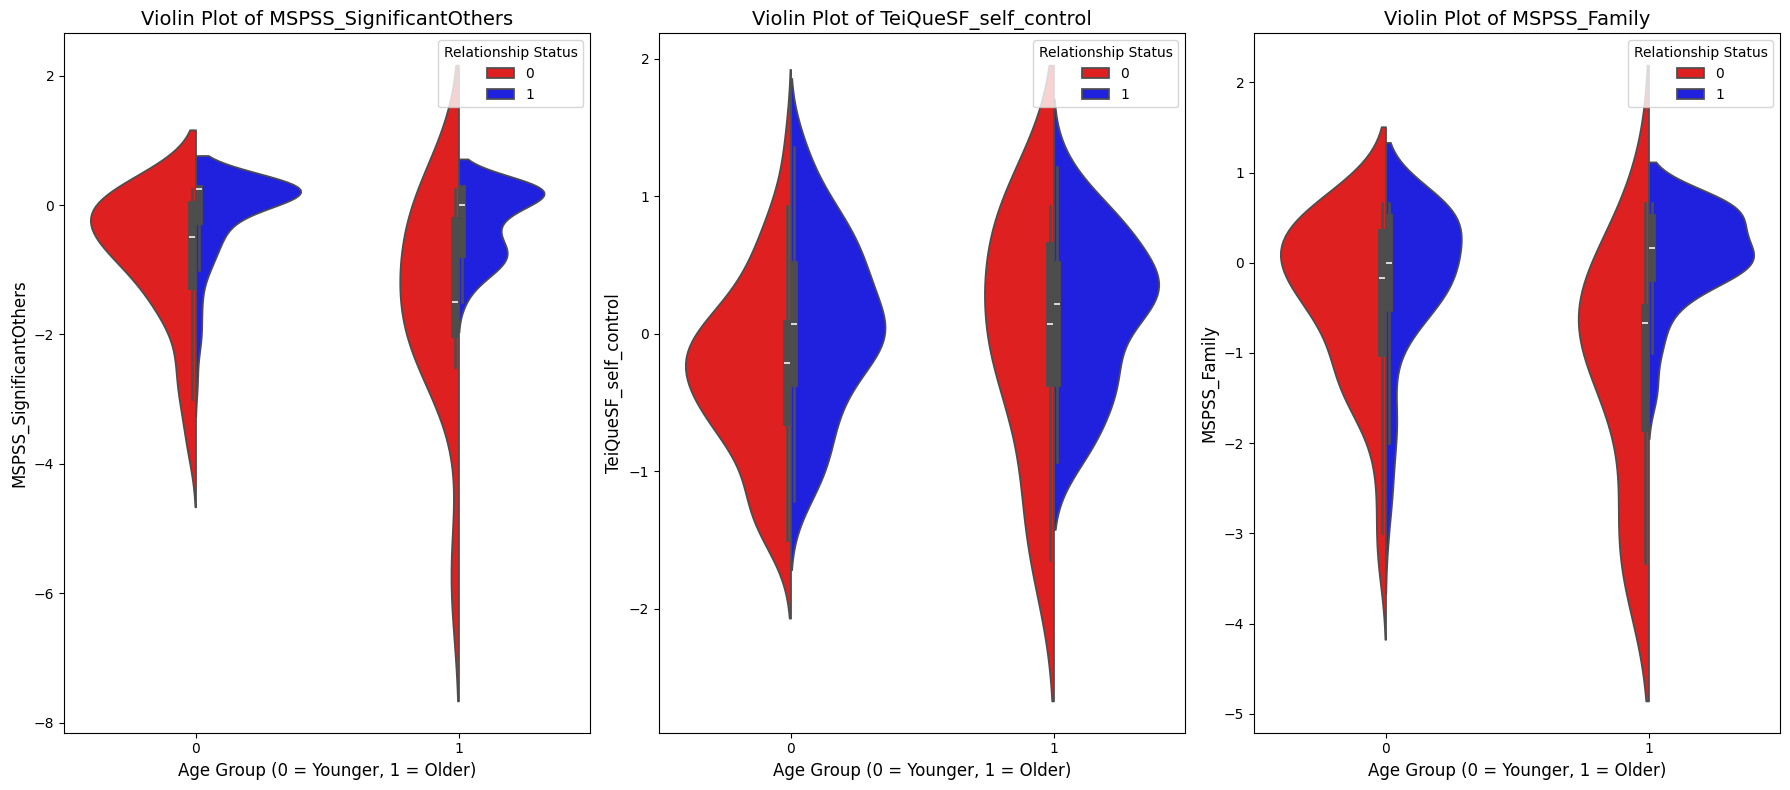

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(18, 8))

for i, feature in enumerate(top_3_features):
    ax = axes[i]
    sns.violinplot(
        x="Age_Group", 
        y=feature, 
        hue="Relationship_Status", 
        data=merged_data_clean_scaled_dataframe, 
        split=True, 
        palette=["red", "blue"], 
        ax=ax
    )
    ax.set_title(f"Violin Plot of {feature}", fontsize=14)
    ax.set_xlabel("Age Group (0 = Younger, 1 = Older)", fontsize=12)
    ax.set_ylabel(feature, fontsize=12)
    ax.legend(title="Relationship Status")

plt.tight_layout()
plt.show()

--------